In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split

In [2]:
data = []
labels = []
classes = 43
current_path = os.getcwd()
print(current_path)

D:\project\traffic sign classification


In [3]:
for i in range(classes):
    path = os.path.join(current_path,"data//train",str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '//' + a)
            image = image.resize((30,30))
            image = np.array(image)
            image = image/255.
            data.append((image))
            labels.append(i)
        except Exception as e:
            print(e)

In [4]:
# converting list to numpy
data = np.array(data)
labels = np.array(labels)

In [5]:
#save labels and data
np.save('./model/data',data)
np.save('./model/target',labels)

In [6]:
#load data and labels
data = np.load('./training/data.npy')
labels = np.load('./training/target.npy')

In [7]:
data.shape,labels.shape

((39209, 30, 30, 3), (39209,))

In [8]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_train.shape

((31367, 30, 30, 3), (31367,), (7842, 30, 30, 3), (31367,))

In [9]:
#convert labels to one hot encoding
y_train = tf.keras.utils.to_categorical(y_train,43)
y_test = tf.keras.utils.to_categorical(y_test,43)

In [10]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(5,5),
            activation='relu',
            input_shape = (30,30,3)
        ),
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(5,5),
            activation='relu'
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(rate=0.25),
        tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='relu'
        ),
        tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='relu'
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(rate=0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512,activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=43,activation='softmax')
    ])
    return model

In [11]:
model = build_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
es = EarlyStopping(monitor='val_loss',patience=5)

In [16]:
history = model.fit(X_train,y_train,batch_size=32,epochs=20,validation_data=(X_test,y_test), callbacks=[es])

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 78s 2ms/sample - loss: 1.0797 - accuracy: 0.6962 - val_loss: 0.1043 - val_accuracy: 0.9695
Epoch 2/20
31367/31367 [==============================] - 70s 2ms/sample - loss: 0.1705 - accuracy: 0.9502 - val_loss: 0.0467 - val_accuracy: 0.9885
Epoch 3/20
31367/31367 [==============================] - 68s 2ms/sample - loss: 0.1077 - accuracy: 0.9679 - val_loss: 0.0395 - val_accuracy: 0.9889
Epoch 4/20
31367/31367 [==============================] - 67s 2ms/sample - loss: 0.0865 - accuracy: 0.9743 - val_loss: 0.0438 - val_accuracy: 0.9888
Epoch 5/20
31367/31367 [==============================] - 67s 2ms/sample - loss: 0.0778 - accuracy: 0.9763 - val_loss: 0.0250 - val_accuracy: 0.9935
Epoch 6/20
31367/31367 [==============================] - 64s 2ms/sample - loss: 0.0682 - accuracy: 0.9790 - val_loss: 0.0292 - val_accuracy: 0.9921- los - ETA: 0s - los
Epoch 7/20
31367/31367 [============

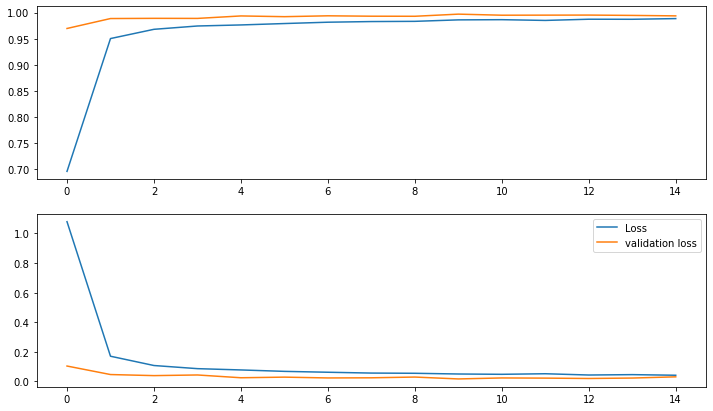

In [17]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,7))
ax1.plot(history.history['accuracy'],label = 'Accuracy')
ax1.plot(history.history['val_accuracy'],label = 'validation accuracy')
ax2.plot(history.history['loss'],label = 'Loss')
ax2.plot(history.history['val_loss'],label = 'validation loss')
plt.legend()
plt.show()

In [18]:
def testing(csv):
    y_test = pd.read_csv(csv)
    labels = y_test['ClassId'].values
    image = 'data/' + y_test['Path'].values
    data = []
    for img in image:
        image = Image.open(img)
        image = image.resize((30,30))
        image = np.array(image)
        image = image/255.
        data.append((image))
    X_test = np.array(data)
    return X_test,labels

In [19]:
X_test, labels = testing('data/Test.csv')

In [20]:
y_pred = model.predict_classes(X_test)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,y_pred)

0.9676167854315123

In [22]:
model.save('./training/model.h5')

In [23]:
from tensorflow.keras.models import load_model
model = load_model('./model/model.h5')

In [24]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [25]:
def test_on_img(img):
    data = []
    image = Image.open(img)
    image = image.resize((30,30))
    image = np.array(image)
    image = image/255.
    data.append(image)
    X_test = np.array(data)
    y_pred = model.predict_classes(X_test)
    return image,y_pred

In [26]:
plot, prediction = test_on_img('./data/Test/00000.png')

In [27]:
s = [str(i) for i in prediction]
a = int("".join(s))

predicted images: Veh > 3.5 tons prohibited


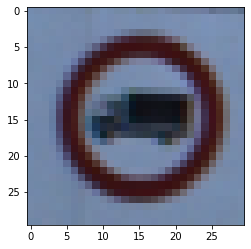

In [28]:
print(f'predicted images: {classes[a]}')
plt.imshow(plot)
plt.show()